In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pylab as plt
import numpy as np

# Local modules
sys.path.append('../src')
from train import train_model
from visualize import imshow, visualize_model
from utils import unpickle

In [2]:
def makeTransforms():
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    return data_transforms


In [3]:
# Script runtime options
root_dir = '/home/jupyter/caltech_birds'
model = 'vgg16'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [4]:
# Get data transforms
data_transforms = makeTransforms()

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

print('Number of data')
print('========================================')
for dataset in dataset_sizes.keys():
    print(dataset,' size:: ', dataset_sizes[dataset],' images')

print('')
print('Number of classes:: ', len(class_names))
print('========================================')
for i_class, class_name in enumerate(class_names):
    print('{} :: {} :: {}'.format(i_class,class_name,(np.array(image_datasets['test'].targets) == i_class).sum()))


Number of data
test  size::  5794  images

Number of classes::  200
0 :: 001.Black_footed_Albatross :: 30
1 :: 002.Laysan_Albatross :: 30
2 :: 003.Sooty_Albatross :: 28
3 :: 004.Groove_billed_Ani :: 30
4 :: 005.Crested_Auklet :: 14
5 :: 006.Least_Auklet :: 11
6 :: 007.Parakeet_Auklet :: 23
7 :: 008.Rhinoceros_Auklet :: 18
8 :: 009.Brewer_Blackbird :: 29
9 :: 010.Red_winged_Blackbird :: 30
10 :: 011.Rusty_Blackbird :: 30
11 :: 012.Yellow_headed_Blackbird :: 26
12 :: 013.Bobolink :: 30
13 :: 014.Indigo_Bunting :: 30
14 :: 015.Lazuli_Bunting :: 28
15 :: 016.Painted_Bunting :: 28
16 :: 017.Cardinal :: 27
17 :: 018.Spotted_Catbird :: 15
18 :: 019.Gray_Catbird :: 29
19 :: 020.Yellow_breasted_Chat :: 29
20 :: 021.Eastern_Towhee :: 30
21 :: 022.Chuck_will_Widow :: 26
22 :: 023.Brandt_Cormorant :: 29
23 :: 024.Red_faced_Cormorant :: 22
24 :: 025.Pelagic_Cormorant :: 30
25 :: 026.Bronzed_Cowbird :: 30
26 :: 027.Shiny_Cowbird :: 30
27 :: 028.Brown_Creeper :: 29
28 :: 029.American_Crow :: 30
29 ::

In [6]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


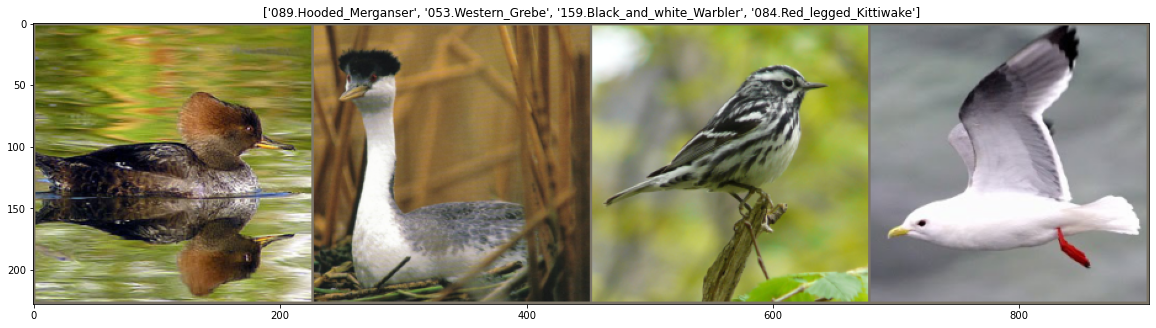

In [7]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
# Load the best model from file
model_ = torch.load(model_file)

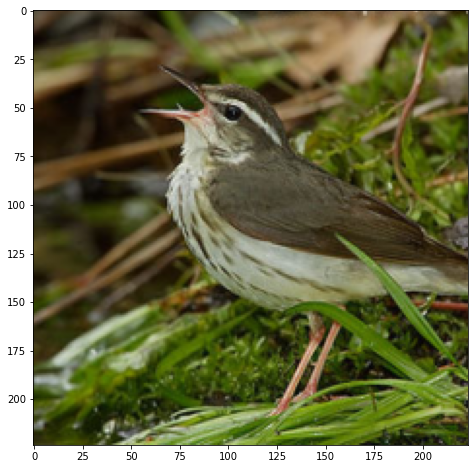

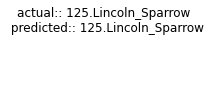

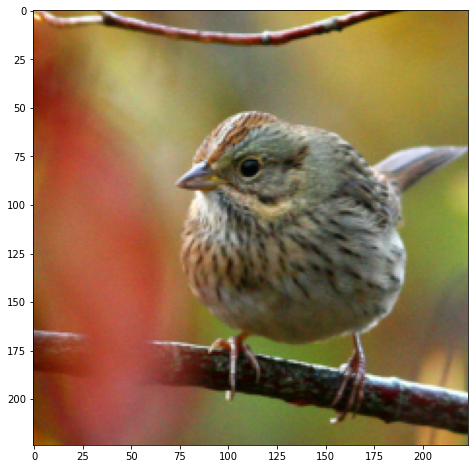

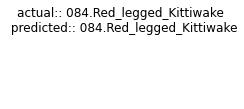

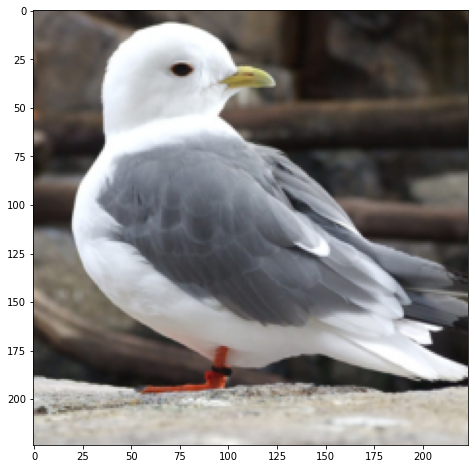

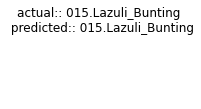

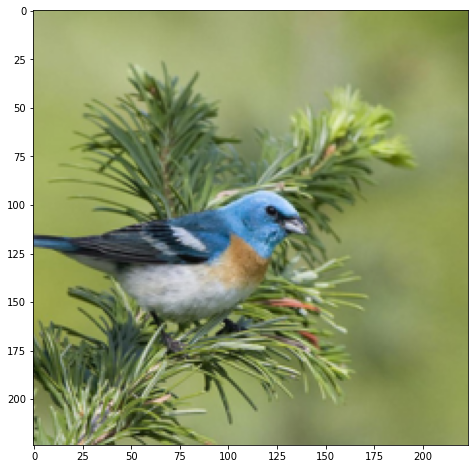

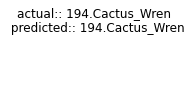

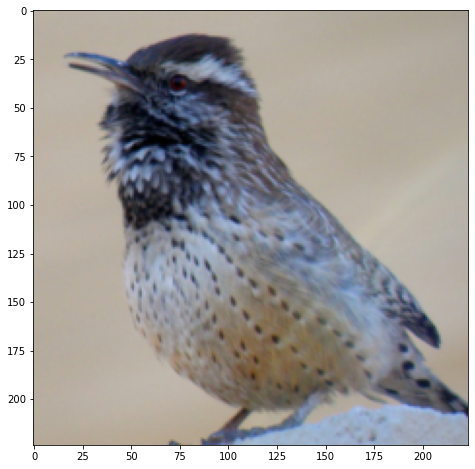

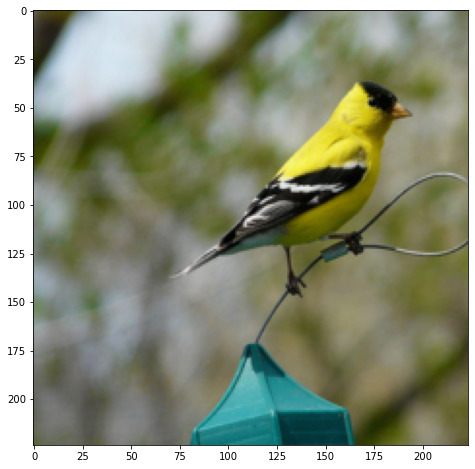

In [9]:
visualize_model(model=model_, class_names=class_names, device=device, dataloaders=dataloaders)

In [10]:
# Load model training history
history = unpickle(model_history)

In [11]:
history.keys()

dict_keys(['epoch', 'train_loss', 'test_loss', 'train_acc', 'test_acc'])

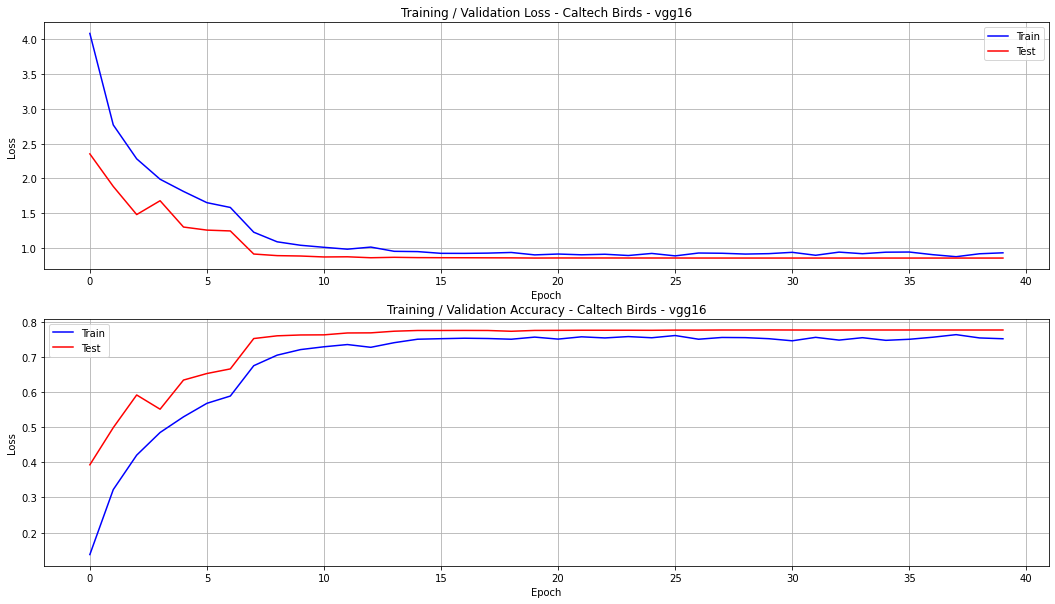

In [12]:
plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_loss'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_loss'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Loss - Caltech Birds - {}'.format(model))
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['train_acc'], 'b-', label='Train')
plt.plot(np.arange(0, np.max(history['epoch'])+1,1), history['test_acc'], 'r-', label='Test')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training / Validation Accuracy - Caltech Birds - {}'.format(model))
plt.legend()

plt.show()

In [13]:
was_training = model_.training
model_.eval()
images_so_far = 0


print('Commencing predictions minibatch..', end='')
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        if i % 25 == 0:
            print('{}..'.format(i), end='')

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        outputs = model_(inputs)
        _, preds = torch.max(outputs, 1)

        if i == 0:
            labels_truth = labels.cpu().numpy()
            labels_pred = preds.cpu().numpy()
        else:
            labels_truth = np.concatenate((labels_truth,labels.cpu().numpy()))
            labels_pred = np.concatenate((labels_pred,preds.cpu().numpy()))

print('Complete.')



Commencing predictions minibatch..0..25..50..75..100..125..150..175..200..225..250..275..300..325..350..375..400..425..450..475..500..525..550..575..600..625..650..675..700..725..750..775..800..825..850..875..900..925..950..975..1000..1025..1050..1075..1100..1125..1150..1175..1200..1225..1250..1275..1300..1325..1350..1375..1400..1425..Complete.


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [15]:
print(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names))

precision    recall  f1-score   support

        001.Black_footed_Albatross       0.60      0.70      0.65        30
              002.Laysan_Albatross       0.96      0.77      0.85        30
               003.Sooty_Albatross       0.65      0.71      0.68        28
             004.Groove_billed_Ani       0.87      0.87      0.87        30
                005.Crested_Auklet       0.77      0.71      0.74        14
                  006.Least_Auklet       0.71      0.91      0.80        11
               007.Parakeet_Auklet       0.88      0.91      0.89        23
             008.Rhinoceros_Auklet       0.71      0.83      0.77        18
              009.Brewer_Blackbird       0.54      0.45      0.49        29
          010.Red_winged_Blackbird       0.96      0.90      0.93        30
               011.Rusty_Blackbird       0.62      0.53      0.57        30
       012.Yellow_headed_Blackbird       0.92      0.88      0.90        26
                      013.Bobolink       1.00  

In [16]:
class_report_df = pd.DataFrame(classification_report(y_true=labels_truth, y_pred=labels_pred, target_names=class_names, output_dict=True))
class_report_df

001.Black_footed_Albatross  002.Laysan_Albatross  \
precision                    0.600000              0.958333   
recall                       0.700000              0.766667   
f1-score                     0.646154              0.851852   
support                     30.000000             30.000000   

           003.Sooty_Albatross  004.Groove_billed_Ani  005.Crested_Auklet  \
precision             0.645161               0.866667            0.769231   
recall                0.714286               0.866667            0.714286   
f1-score              0.677966               0.866667            0.740741   
support              28.000000              30.000000           14.000000   

           006.Least_Auklet  007.Parakeet_Auklet  008.Rhinoceros_Auklet  \
precision          0.714286             0.875000               0.714286   
recall             0.909091             0.913043               0.833333   
f1-score           0.800000             0.893617               0.769231   
support           11.000000            23.000000              18.000000   

           009.Brewer_Blackbird  010.Red_winged_Blackbird  ...  \
precision              0.541667                  0.964286  ...   
recall                 0.448276                  0.900000  ...   
f1-score               0.490566                  0.931034  ...   
support               29.000000                 30.000000  ...   

           194.Cactus_Wren  195.Carolina_Wren  196.House_Wren  197.Marsh_Wren  \
precision         0.896552           0.812500        0.769231        0.923077   
recall            0.866667           0.866667        0.666667        0.800000   
f1-score          0.881356           0.838710        0.714286        0.857143   
support          30.000000          30.000000       30.000000       30.000000   

           198.Rock_Wren  199.Winter_Wren  200.Common_Yellowthroat  accuracy  \
precision       0.916667         0.736842                      0.9  0.777011   
recall          0.733333         0.933333                      0.9  0.777011   
f1-score        0.814815         0.823529                      0.9  0.777011   
support        30.000000        30.000000                     30.0  0.777011   

             macro avg  weighted avg  
precision     0.780581      0.780711  
recall        0.778995      0.777011  
f1-score      0.775729      0.774978  
support    5794.000000   5794.000000  

[4 rows x 203 columns]

In [17]:
plt.figure(figsize=(10,35))
class_report_df.transpose()['precision'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Precision Score')
plt.grid(True)
plt.title(model)

plt.figure(figsize=(10,35))
class_report_df.transpose()['recall'][:-3].sort_values().plot(kind='barh')
plt.xlabel('Recall Score')
plt.title(model)
plt.grid(True)

plt.figure(figsize=(10,35))
class_report_df.transpose()['f1-score'][:-3].sort_values().plot(kind='barh')
plt.xlabel('F1 Score')
plt.title(model)
plt.grid(True)

plt.show()

In [18]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true=labels_truth, y_pred=labels_pred), index=class_names, columns=class_names)

In [ ]:
plt.figure(figsize=(40,40))
plt.imshow(confusion_matrix_df, cmap='Reds')
plt.xticks(np.arange(0,len(class_names),1), class_names, rotation=90)
plt.yticks(np.arange(0,len(class_names),1), class_names)
plt.colorbar()
plt.grid(True)
plt.title('CalTech Birds 200 Dataset - Confusion Matrix - Model {}'.format(model))
plt.show()

In [ ]:
class_report_df.to_pickle(os.path.join(output_dir,'classification_report.pkl'))
confusion_matrix_df.to_pickle(os.path.join(output_dir,'confusion_matrix.pkl'))